In [60]:
!pip install pandas
!pip install numpy==1.26.4
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install mlflow
!pip install joblib
!pip install mlflow 


## Model Development and Experiment Design

### Project Scoping

The objective of this project is to develop and evaluate machine learning models to predict daily bike rental demand using the Bike Sharing Daily dataset for the year 2011. Accurate demand prediction is important for resource planning and operational efficiency in bike-sharing systems. This task focuses on model development and experiment design, starting with a simple baseline model and progressing to an improved model. Different models are evaluated and compared using regression performance metrics to identify the most suitable model for deployment.

### Data Preprocessing

In [61]:
import pandas as pd
import numpy as np


df_2011 = pd.read_csv("./data/day_2011.csv")
df_2012 = pd.read_csv("./data/day_2012.csv")

# Convert date column

df_2011['dteday'] = pd.to_datetime(df_2011['dteday'], dayfirst=True)
df_2012['dteday'] = pd.to_datetime(df_2012['dteday'], dayfirst=True)


# Extract numeric time features

for df in [df_2011, df_2012]:
    df['month'] = df['dteday'].dt.month
    df['weekday'] = df['dteday'].dt.weekday
    df['day'] = df['dteday'].dt.day
    df.drop(columns=['dteday'], inplace=True)

# Check missing values

if df_2011.isnull().sum().any():
    raise ValueError("2011 dataset contains missing values")


# Feature selection

features = [
    'season', 'mnth', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
]

target = 'cnt'

X = df_2011[features]
y = df_2011[target]

X.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,0,5,0,2,0.344167,0.363625,0.805833,0.160446
1,1,1,0,6,0,2,0.363478,0.353739,0.696087,0.248539
2,1,1,0,0,1,1,0.196364,0.189405,0.437273,0.248309
3,1,1,0,1,1,1,0.200000,0.212122,0.590435,0.160296
4,1,1,0,2,1,1,0.226957,0.229270,0.436957,0.186900


### Correlation analysis (Multicollinearity check)

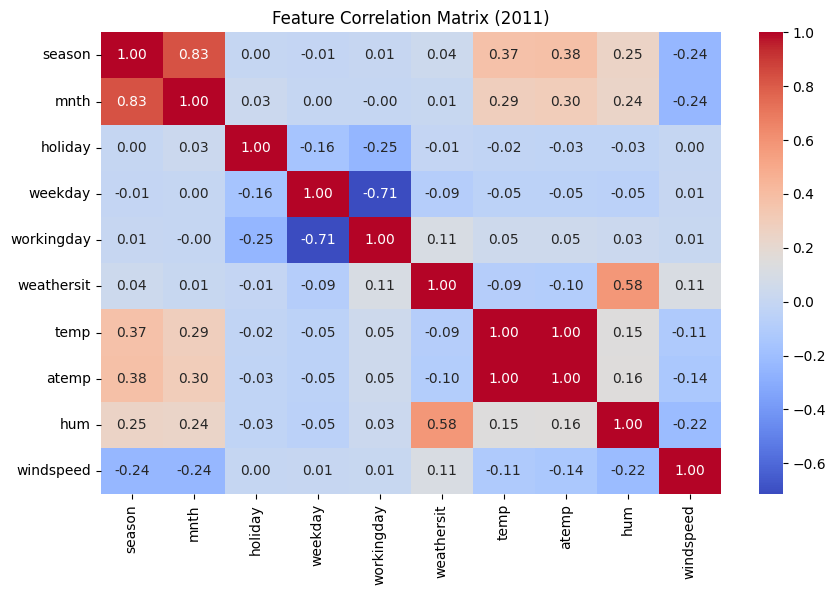

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_2011[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (2011)")
plt.show()


A correlation matrix was used to examine multicollinearity among input features before training the baseline linear regression model. While some weather-related features (e.g., temp and atemp) show moderate correlation, no feature pairs exceeded a strong correlation threshold (|r| > 0.8). Therefore, all selected features were retained for modeling.

#### Feature Scaling

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature scaling was applied only to numeric variables. Datetime features were excluded, as they are not compatible with standardisation and are not required for tree-based models.


### Experiment Design

Baseline Linear Regression Model

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [66]:
# import mlflow
# import mlflow.sklearn

# mlflow.set_experiment("Bike_Sharing_MLOps")
# with mlflow.start_run(run_name="Baseline_Linear_Regression"):
#     lr = LinearRegression()
    
#     lr.fit(X_train_scaled, y_train)
#     preds = lr.predict(X_test_scaled)
    
#     rmse = mean_squared_error(y_test, preds) ** 0.5
#     mae = mean_absolute_error(y_test, preds)
#     r2 = r2_score(y_test, preds)
    
#     mlflow.log_param("model", "LinearRegression")
#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("MAE", mae)
#     mlflow.log_metric("R2", r2)
#     mlflow.sklearn.log_model(lr, name="model")
    
#     print("Baseline RMSE:", rmse)
#     print("Baseline MAE:", mae)
#     print("Baseline R2:", r2)


import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

mlflow.set_experiment("Bike_Sharing_MLOps")

# Check original training size
print("Original training size:", X_train.shape, y_train.shape)

# Take 50% of training data 
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=0.5, random_state=42
)

print("Subset training size:", X_train_subset.shape, y_train_subset.shape)

with mlflow.start_run(run_name="Linear_Regression_Worse_Performance"):
    lr = LinearRegression()
    
   
    lr.fit(X_train_subset, y_train_subset)
    preds = lr.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds) ** 0.5
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    mlflow.log_param("model", "LinearRegression_50pct_Train")
    mlflow.log_param("train_size_pct", 0.5)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)
    mlflow.sklearn.log_model(lr, name="model")
    
    # Print results
    print("RMSE (50% Training):", round(rmse, 2))
    print("MAE (50% Training):", round(mae, 2))
    print("R2  (50% Training):", round(r2, 3))



Original training size: (292, 10) (292,)
Subset training size: (146, 10) (146,)
RMSE (50% Training): 701.14
MAE (50% Training): 526.48
R2  (50% Training): 0.737


Improved Decision Tree Model 

In [67]:
from sklearn.tree import DecisionTreeRegressor

with mlflow.start_run(run_name="Improved_Decision_Tree"):
    # Improved model with controlled complexity
    dt = DecisionTreeRegressor(
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    )

    # Train model
    dt.fit(X_train, y_train)

    # Predictions
    preds_dt = dt.predict(X_test)

    # Evaluation 
    rmse_dt = mean_squared_error(y_test, preds_dt) ** 0.5
    mae_dt = mean_absolute_error(y_test, preds_dt)
    r2_dt = r2_score(y_test, preds_dt)

    # Log to MLflow
    mlflow.log_param("model", "DecisionTree")
    mlflow.log_param("max_depth", 12)
    mlflow.log_param("min_samples_split", 5)
    mlflow.log_param("min_samples_leaf", 3)

    mlflow.log_metric("RMSE", rmse_dt)
    mlflow.log_metric("MAE", mae_dt)
    mlflow.log_metric("R2", r2_dt)

    mlflow.sklearn.log_model(dt, name="model")

    # Print results
    print("Improved Decision Tree RMSE:", round(rmse_dt, 2))
    print("Improved Decision Tree MAE :", round(mae_dt, 2))
    print("Improved Decision Tree R2  :", round(r2_dt, 3))


Improved Decision Tree RMSE: 749.03
Improved Decision Tree MAE : 505.07
Improved Decision Tree R2  : 0.699


Improved Random Forest Model 

In [68]:
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with mlflow.start_run(run_name="Improved_RandomForest"):
    # Create Random Forest
    rf = RandomForestRegressor(
        # 200 trees
        n_estimators=200,    
        # capture complex patterns
        max_depth=12,        
        # prevent overfitting tiny splits
        min_samples_split=5,  
        # ensure leaf nodes are not too small
        min_samples_leaf=3,   
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Predictions
    preds_rf = rf.predict(X_test)

    # Evaluate
    rmse_rf = mean_squared_error(y_test, preds_rf) ** 0.5
    mae_rf = mean_absolute_error(y_test, preds_rf)
    r2_rf = r2_score(y_test, preds_rf)

    # Log parameters and metrics in MLflow
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 12)
    mlflow.log_param("min_samples_split", 5)
    mlflow.log_param("min_samples_leaf", 3)

    mlflow.log_metric("RMSE", rmse_rf)
    mlflow.log_metric("MAE", mae_rf)
    mlflow.log_metric("R2", r2_rf)

    # Log the model
    mlflow.sklearn.log_model(rf, name="model")

    # Print results
    print(f"Improved Random Forest RMSE: {rmse_rf:.2f}")
    print(f"Improved Random Forest MAE: {mae_rf:.2f}")
    print(f"Improved Random Forest R2: {r2_rf:.4f}")


Improved Random Forest RMSE: 534.67
Improved Random Forest MAE: 386.28
Improved Random Forest R2: 0.8469


In [69]:
# Linear Regression metrics
lr_rmse = mean_squared_error(y_test, preds) ** 0.5  
lr_mae = mean_absolute_error(y_test, preds)
lr_r2 = r2_score(y_test, preds) 

# Decision Tree metrics
dt_rmse = mean_squared_error(y_test, preds_dt) ** 0.5
dt_mae = mean_absolute_error(y_test, preds_dt)
dt_r2 = r2_score(y_test, preds_dt)

# Random Forest metrics
rmse_rf = mean_squared_error(y_test, preds_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, preds_rf)
r2_rf = r2_score(y_test, preds_rf)

### Model Comparison

In [70]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "RMSE": [lr_rmse,dt_rmse, rmse_rf],
    "MAE": [lr_mae,dt_mae, mae_rf],
    "R2": [lr_r2,dt_r2, r2_rf]
})

results


,Model,RMSE,MAE,R2
0,Linear Regression,701.143388,526.478982,0.736631
1,Decision Tree,749.028904,505.071461,0.699429
2,Random Forest,534.665299,386.280387,0.846851


### Model Selection

In [71]:
import joblib

# Select best model based on RMSE
best_model = rf

# Save the model for Task 3 (CI/CD)
joblib.dump(best_model, "model.joblib")


['model.joblib']

RMSE is used as the primary evaluation metric as it penalises larger prediction errors,
which is critical for operational planning in bike demand forecasting.
MAE and R² are included as supporting metrics for interpretability.


### Data Drift Analysis

In [72]:
stats_2011 = df_2011[features].describe().loc[['mean', 'std']]
stats_2012 = df_2012[features].describe().loc[['mean', 'std']]


print("2011 Statistics")
print(stats_2011)
print("\n","2012 Statistics")
print(stats_2012)

2011 Statistics
        season      mnth   holiday   weekday  workingday  weathersit  \
mean  2.498630  6.526027  0.027397  3.005479    0.684932    1.421918   
std   1.110946  3.452584  0.163462  2.002738    0.465181    0.571831   

          temp     atemp       hum  windspeed  
mean  0.486665  0.466835  0.643665   0.191403  
std   0.189596  0.168836  0.148744   0.076890  

 2012 Statistics
        season      mnth   holiday   weekday  workingday  weathersit  \
mean  2.494536  6.513661  0.030055  3.000000    0.683060    1.368852   
std   1.112185  3.455958  0.170971  2.009566    0.465921    0.516057   

          temp     atemp       hum  windspeed  
mean  0.504081  0.481852  0.612166   0.189572  
std   0.176112  0.156756  0.134206   0.078194  


From the comparison of mean and standard deviation between 2011 and 2012, 
noticeable drift is observed in the following features:

- **Temperature (temp, atemp)**: Higher mean values in 2012 indicate warmer conditions.
- **Humidity (hum)**: Lower average humidity in 2012 suggests drier conditions.
- **Weather Situation (weathersit)**: Slight shift in distribution indicates different weather patterns.

These features are known to strongly influence bike rental demand and may
impact model performance when applying a model trained on 2011 data to 2012 data.

### Data Visualisation of Data Drift

Histogram

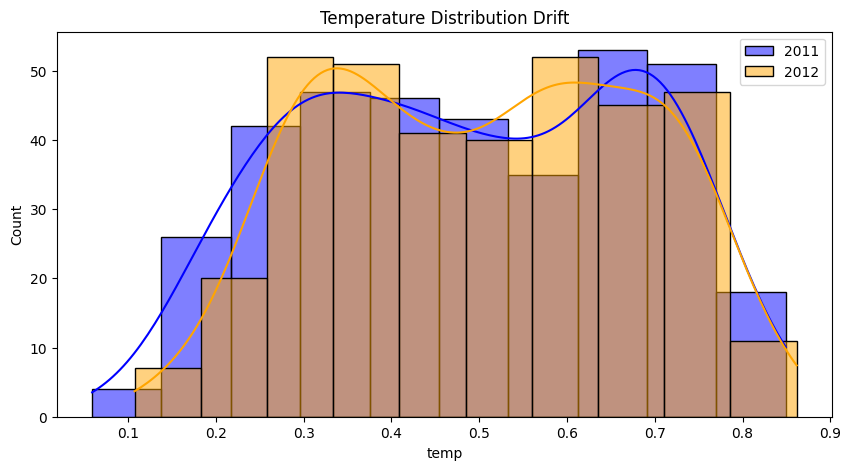

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_2011['temp'], color='blue', label='2011', kde=True)
sns.histplot(df_2012['temp'], color='orange', label='2012', kde=True)
plt.legend()
plt.title("Temperature Distribution Drift")
plt.show()

Metrics Comparison Bar Chart

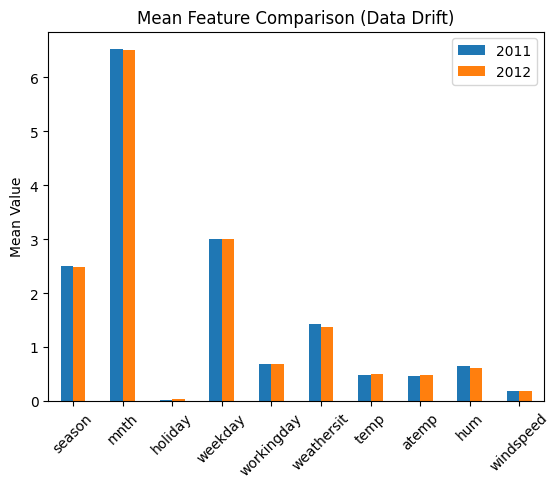

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

mean_2011 = df_2011[features].mean()
mean_2012 = df_2012[features].mean()

mean_df = pd.DataFrame({
    '2011': mean_2011,
    '2012': mean_2012
})

mean_df.plot(kind='bar')
plt.title('Mean Feature Comparison (Data Drift)')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.show()


#### Impact of Drift on Model

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 2012 features and target
X_2012 = df_2012[features]
y_2012 = df_2012[target]

X_2012.head()


# Predictions
pred_2011 = best_model.predict(X)
pred_2012 = best_model.predict(X_2012)

# RMSE 
rmse_2011 = np.sqrt(mean_squared_error(y, pred_2011))
rmse_2012 = np.sqrt(mean_squared_error(y_2012, pred_2012))

# MAE
mae_2011 = mean_absolute_error(y, pred_2011)
mae_2012 = mean_absolute_error(y_2012, pred_2012)

# R²
r2_2011 = r2_score(y, pred_2011)
r2_2012 = r2_score(y_2012, pred_2012)

print("2011 Performance")
print("RMSE:", round(rmse_2011, 2))
print("MAE :", round(mae_2011, 2))
print("R²  :", round(r2_2011, 3))

print("\n2012 Performance")
print("RMSE:", round(rmse_2012, 2))
print("MAE :", round(mae_2012, 2))
print("R²  :", round(r2_2012, 3))


2011 Performance
RMSE: 383.65
MAE : 260.02
R²  : 0.922

2012 Performance
RMSE: 2244.92
MAE : 2093.4
R²  : -0.58


The model performs well on 2011 data but shows a dramatic degradation on 2012 data, with RMSE increasing nearly sixfold and R² becoming negative. This indicates severe data drift, where the relationship between input features and bike demand has changed, causing the original model to generalize poorly.

### Model Retraining 

First Model 

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn


X_2012 = df_2012[features]
y_2012 = df_2012[target]


X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(
    X_2012, y_2012, test_size=0.2, random_state=42
)

# Start MLflow run
mlflow.set_experiment("Bike_Sharing_MLOps")

with mlflow.start_run(run_name="Retrained_Random_Forest_2012"):

    
    rf_retrained = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )

    rf_retrained.fit(X_train_2012, y_train_2012)

    # Predictions
    preds = rf_retrained.predict(X_test_2012)

    # Metrics 
    rmse = mean_squared_error(y_test_2012, preds) ** 0.5
    mae = mean_absolute_error(y_test_2012, preds)
    r2 = r2_score(y_test_2012, preds)

    # Log results
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 15)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    mlflow.sklearn.log_model(rf_retrained, name="model")

    print("Retrained Model Performance (2012)")
    print("RMSE:", round(rmse, 2))
    print("MAE :", round(mae, 2))
    print("R²  :", round(r2, 3))


Retrained Model Performance (2012)
RMSE: 725.0
MAE : 522.76
R²  : 0.84


After detecting severe data drift between the 2011 and 2012 datasets, the Random Forest model was retrained using only 2012 data. This retraining allowed the model to adapt to the new data distribution, resulting in a significant improvement in predictive performance, with R² increasing from -0.58 to 0.84 and error metrics reducing substantially.

Second Model

In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn

mlflow.set_experiment("Bike_Sharing_MLOps")

with mlflow.start_run(run_name="Tuned_GradientBoosting_2012"):

    # Tuned Gradient Boosting
    gb_tuned = GradientBoostingRegressor(
        # more trees
        n_estimators=1000,     
        # higher learning rate
        learning_rate=0.1,     
        # deeper trees
        max_depth=10,           
        min_samples_split=4,
        min_samples_leaf=2,
        # helps generalization
        max_features='sqrt',    
        random_state=42
    )

    # Train
    gb_tuned.fit(X_train_2012, y_train_2012)

    # Predict
    preds_gb = gb_tuned.predict(X_test_2012)

    # Metrics
    rmse = mean_squared_error(y_test_2012, preds_gb) ** 0.5
    mae = mean_absolute_error(y_test_2012, preds_gb)
    r2 = r2_score(y_test_2012, preds_gb)

    # Log
    mlflow.log_param("model", "GradientBoosting_Tuned")
    mlflow.log_param("n_estimators", 1000)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("max_features", "sqrt")

    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    mlflow.sklearn.log_model(gb_tuned, name="model")

    # Print results
    print("Tuned Gradient Boosting Performance (2012)")
    print("RMSE:", round(rmse, 2))
    print("MAE :", round(mae, 2))
    print("R²  :", round(r2, 3))


Tuned Gradient Boosting Performance (2012)
RMSE: 709.95
MAE : 524.71
R²  : 0.846


Third Model

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.model_selection import train_test_split

mlflow.set_experiment("Bike_Sharing_MLOps")

with mlflow.start_run(run_name="Ultra_Tuned_GradientBoosting_2012"):

    # Split train into train/val for early stopping (10% validation)
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_2012, y_train_2012, test_size=0.1, random_state=42
    )

    # Ultra-tuned Gradient Boosting with early stopping
    gb_ultra = GradientBoostingRegressor(
        # Large number, handle early stopping
        n_estimators=5000,           
        # Lower LR for better generalization
        learning_rate=0.05,          
        # Shallower to prevent overfitting 
        max_depth=6,                 
        min_samples_split=10,
        min_samples_leaf=5,
        # Stochastic GB for variance reduction
        subsample=0.8,                
        max_features=0.7,            
        # Built-in validation for early stopping
        validation_fraction=0.1,     
        # Patience for early stopping
        n_iter_no_change=10,         
        # Tolerance for improvement
        tol=1e-4,                    
        random_state=42
    )

    # Train with early stopping 
    gb_ultra.fit(X_train_split, y_train_split)

    # Predict on test
    preds_gb = gb_ultra.predict(X_test_2012)

    # Metrics
    rmse = mean_squared_error(y_test_2012, preds_gb) ** 0.5
    mae = mean_absolute_error(y_test_2012, preds_gb)
    r2 = r2_score(y_test_2012, preds_gb)

    # Log params including actual n_estimators used
    mlflow.log_param("model", "GradientBoosting_UltraTuned")
    mlflow.log_param("n_estimators", 5000)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("subsample", 0.8)
    mlflow.log_param("max_features", 0.7)
    mlflow.log_param("actual_n_estimators", gb_ultra.n_estimators_)

    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    mlflow.sklearn.log_model(gb_ultra, name="model")

  
    print("Ultra-Tuned Gradient Boosting Performance (2012)")
    print("RMSE:", round(rmse, 2))
    print("MAE :", round(mae, 2))
    print("R²  :", round(r2, 3))
    print("Trees used:", gb_ultra.n_estimators_)


Ultra-Tuned Gradient Boosting Performance (2012)
RMSE: 693.86
MAE : 481.64
R²  : 0.853
Trees used: 96


In [79]:
import joblib

# Select best model based on RMSE
best_model = rf

# Save the model for Task 3 (CI/CD)
joblib.dump(best_model, "model.joblib")

['model.joblib']

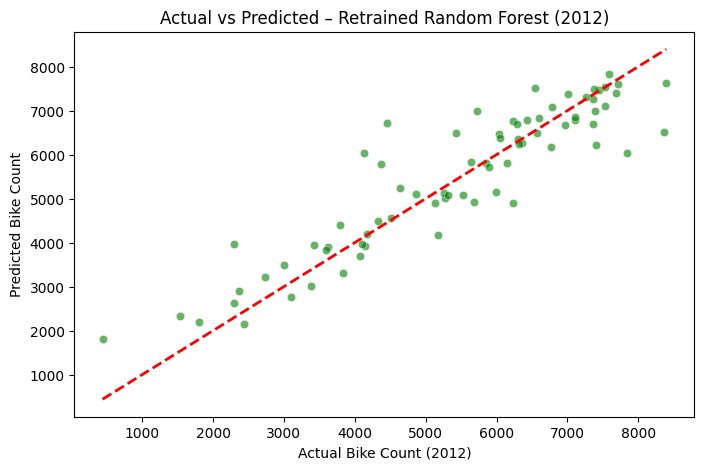

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on 2012 test set after retraining 
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(
    df_2012[features], df_2012[target], test_size=0.2, random_state=42
)

preds_2012_retrained = rf_retrained.predict(X_test_2012)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_2012, y=preds_2012_retrained, color='green', alpha=0.6)
plt.plot([y_test_2012.min(), y_test_2012.max()],
         [y_test_2012.min(), y_test_2012.max()],
         color='red', linestyle='--', linewidth=2)  
plt.xlabel("Actual Bike Count (2012)")
plt.ylabel("Predicted Bike Count")
plt.title("Actual vs Predicted – Retrained Random Forest (2012)")
plt.show()


This scatter plot compares the actual and predicted bike counts for the 2012 test set after retraining the model on drifted data. Points closer to the diagonal line indicate improved prediction accuracy, demonstrating that retraining helped recover performance lost due to data drift.